# Imports

In [1]:
import os
import time
import numpy as np
import pandas as pd

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns

# Variables Initialization

In [2]:
# Mask proportion
NUM = 50
MASK_PROPORTION = NUM/100  
PERCENTAGE = str(NUM)
LOSS_NAME = 'BCE' # 'MSE'

LOSS = tf.keras.losses.BinaryCrossentropy() if LOSS_NAME == 'BCE' else tf.keras.losses.MeanSquaredError() 

# Set stats and skills
NUM_STATS = 18 
NUM_SKILLS = 4

AUTO = tf.data.AUTOTUNE
BUFFER_SIZE = 1024
NUM_CLASSES = NUM_STATS

N_MISSING = 0
MAX_MISSING = 6
CNT_NAME = 'United States'
ALL_CNTS = True
CNTS = ['Brazil', 'Canada', 'Colombia', 'United States']
INTERMEDIATE_DIM = 12

# Encoder and Decoder
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 1
DEC_PROJECTION_DIM = 18
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

# Optimizer
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

BATCH_SIZE = 5 
NUM_EPOCHS = 100

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# Load and Extraction of dataset

In [3]:
# Cognitive scince data
cog = pd.read_csv('../input_data/cog_science.csv', sep=';')

# Skills data
main_items = pd.read_excel(
    '../input_data/PISA2015_TechRep_Final-AnnexA.xlsx', sheet_name=None, skiprows=1)

## Extract items related to specific survey

In [4]:
sheets = ['Table 1', 'Table 2', 'Table 11', 'Table 12']

survey = ['CNT', 'CNTSTUID']
#survey = []

for s in sheets[:2]:
    survey.extend(main_items[s]['CBA item ID in main survey analysis output'][main_items[s]
                  ['2015 field trial and main survey cluster'].isin(['S01', 'S01, U1', 'S01, U2'])].values.tolist())
    #survey.extend(main_items[s]['PBA item ID in main survey analysis output'][main_items[s]
    #              ['2015 field trial and main survey cluster'].isin(['S01', 'S01, U1', 'S01, U2'])].values.tolist())

#for s in sheets[2:]:
#    survey.extend(main_items[s]['Item ID\nin analysis output'][main_items[s]
#                  ['2015 main survey cluster'].isin(['S12'])].values.tolist())


## Arrange selected itens and abilities to one dataframe. 

In [5]:
generic_id = main_items['Table 1'][main_items['Table 1']['CBA item ID in main survey analysis output'].isin(
    survey)]['Generic ID'].tolist()
generic_id.extend(main_items['Table 2'][main_items['Table 2']['CBA item ID in main survey analysis output'].isin(
    survey)]['Generic ID'].tolist())

rm = main_items['Table 3'][main_items['Table 3']['Generic ID'].isin(generic_id)].reset_index(drop=True)
rm = rm.append(main_items['Table 4'][main_items['Table 4']['Generic ID'].isin(generic_id)], ignore_index=True)

rm2 = main_items['Table 5'][main_items['Table 5']['Generic ID'].isin(generic_id)].reset_index(drop=True)
rm2 = rm2.append(main_items['Table 6'][main_items['Table 6']['Generic ID'].isin(generic_id)], ignore_index=True)

ref = pd.concat([rm, rm2], axis=1)

ref = ref.loc[:, ~ref.columns.duplicated()]

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_17392/66676006.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rm = rm.append(main_items['Table 4'][main_items['Table 4']['Generic ID'].isin(generic_id)], ignore_index=True)
/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_17392/66676006.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rm2 = rm2.append(main_items['Table 6'][main_items['Table 6']['Generic ID'].isin(generic_id)], ignore_index=True)


## Set Q-Matrix initial values.

In [6]:
c = ['Items', '1', '2', '3', '4', '5']

q_matrix = pd.DataFrame(columns=c)
q_matrix['Items'] = generic_id
q_matrix.iloc[:, 1:] = 0
#print(q_matrix)


/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_17392/2573983023.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  q_matrix.iloc[:, 1:] = 0


## Extract abilities from survey's items.

In [7]:
for i, r in ref.iterrows():
    seq = None
    if 'Hazards' in r['Context 2']:
        seq = '1'
    elif 'Natural Resources' in r['Context 2']:
        seq = '2'
    elif 'Frontiers' in r['Context 2']:
        seq = '3'
    elif 'Health & Disease' in r['Context 2']:
        seq = '4'
    elif 'Environmental Quality' in r['Context 2']:
        seq = '5'

    q_matrix.loc[q_matrix.index[i], seq] = 1


In [8]:
q_matrix

,Items,1,2,3,4,5
0,S269Q01,0,0,0,0,1
1,S269Q03,0,0,0,0,1
2,S269Q04,0,0,0,0,1
3,S408Q01,0,1,0,0,0
4,S408Q03,0,1,0,0,0
5,S408Q04,0,1,0,0,0
6,S408Q05,0,1,0,0,0
7,S466Q01,1,0,0,0,0
8,S466Q05,1,0,0,0,0
9,S466Q07,1,0,0,0,0


In [9]:

q = q_matrix.loc[:, (q_matrix != 0).any(axis=0)]
print(q)


      Items  1  2  3  5
0   S269Q01  0  0  0  1
1   S269Q03  0  0  0  1
2   S269Q04  0  0  0  1
3   S408Q01  0  1  0  0
4   S408Q03  0  1  0  0
5   S408Q04  0  1  0  0
6   S408Q05  0  1  0  0
7   S466Q01  1  0  0  0
8   S466Q05  1  0  0  0
9   S466Q07  1  0  0  0
10  S519Q01  0  0  1  0
11  S519Q02  0  0  1  0
12  S519Q03  0  0  1  0
13  S521Q02  0  0  1  0
14  S521Q06  0  0  1  0
15  S527Q01  0  0  1  0
16  S527Q03  0  0  1  0
17  S527Q04  0  0  1  0


## Set Q-Matrix

In [10]:
Q = q.iloc[:,1:].T
Q.to_csv('../input_data/qmatrix_4D_PISA15.csv', sep=';', header=False, index=False)

# For visualization purpose, percentage of most answered (less missing response) and most participation by country 

In [11]:
# Percentage of most answered (less missing response)
s01 = cog[survey]

d = dict()
for c in s01.CNT.unique().tolist():
    cnt = s01['CNT'].isin([c])
    cnt_df = s01[cnt]
    cnt_df = cnt_df.reset_index(drop=True)
    shape = cnt_df.iloc[:, 2:].shape
    d[c] = cnt_df[cnt_df.iloc[:, 2:] == -1].count().sum() / (shape[0] * shape[1])

d_sorted = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
print(d_sorted)


{'Chinese Taipei': 0.8865680678083376, 'Ireland': 0.8870405852638913, 'North Carolina (USA)': 0.8884178295943002, 'Macao': 0.8886158276238705, 'United Kingdom': 0.8888300251936616, 'Finland': 0.889058899089501, 'Singapore': 0.8893158898882529, 'Costa Rica': 0.8893339159141664, 'Netherlands': 0.8895904260806767, 'Estonia': 0.8903008969234135, 'Latvia': 0.8912051299605213, 'Spain': 0.8917260490894695, 'Canada': 0.8917915821894284, 'United Arab Emirates': 0.8919162686368164, 'Belgium': 0.8919916186002602, 'New Zealand': 0.8921951819075713, 'Slovenia': 0.8922191001491657, 'Spain (Regions)': 0.8927982266213011, 'Korea': 0.8928308347767226, 'Turkey': 0.8929884082555838, 'Greece': 0.8930364746525267, 'Germany': 0.8930658056580566, 'Hong Kong': 0.8932533018183326, 'Australia': 0.8933815095205322, 'B-S-J-G (China)': 0.8933994964378056, 'United States': 0.893936741363212, 'Thailand': 0.8942363384113899, 'Poland': 0.8944841447074587, 'Massachusettes (USA)': 0.8946394942157654, 'Czech Republic': 0

In [12]:
#  Most participation (ascending order)
d2 = dict()
for c in s01.CNT.unique().tolist():
    cnt = s01['CNT'].isin([c])
    cnt_df = s01[cnt]
    cnt_df = cnt_df.reset_index(drop=True)
    shape = cnt_df.iloc[:, 2:].shape
    d2[c] = shape[0]

d_sorted2 = {k: v for k, v in sorted(d2.items(), key=lambda item: item[1])}
print(d_sorted2)

{'Puerto Rico (USA)': 1398, 'Massachusettes (USA)': 1652, 'Argentina (Ciudad Autónoma de Buenos)': 1657, 'North Carolina (USA)': 1887, 'Iceland': 3371, 'Malta': 3634, 'Macao': 4476, 'Poland': 4478, 'New Zealand': 4520, 'Lebanon': 4546, 'Trinidad and Tobago': 4692, 'Dominican Republic': 4740, 'Kosovo': 4826, 'Latvia': 4869, 'Romania': 4876, 'Albania': 5215, 'Luxembourg': 5299, 'Georgia': 5316, 'FYROM': 5324, 'Moldova': 5325, 'Hong Kong': 5359, 'Tunisia': 5375, 'Netherlands': 5385, 'Norway': 5456, 'Sweden': 5458, 'Algeria': 5519, 'Greece': 5532, 'Korea': 5581, 'Estonia': 5587, 'Hungary': 5658, 'Montenegro': 5665, 'United States': 5712, 'Ireland': 5741, 'Croatia': 5809, 'Vietnam': 5826, 'Switzerland': 5860, 'Finland': 5882, 'Turkey': 5895, 'Bulgaria': 5928, 'Russian Federation': 6036, 'Uruguay': 6062, 'France': 6108, 'Singapore': 6115, 'Slovak Republic': 6350, 'Slovenia': 6406, 'Germany': 6504, 'Indonesia': 6513, 'Lithuania': 6525, 'Israel': 6598, 'Japan': 6647, 'Spain': 6736, 'Costa Rica

# Helper Functions


In [13]:
# Select country data by name
def select_cnt(country):
    return cog[cog['CNT'] == country][survey].reset_index(drop=True)

# Select response data of contry data by number of missing
def select_nmissing(nmissing, max_missing, country):
    remove_rows = country[country == -1].count(axis=1) > nmissing
    # This is none missing for training
    train_missing = country[~remove_rows].reset_index(drop=True)
    temp = country[remove_rows].reset_index(drop=True)
    remove_rows = temp[temp == -1].count(axis=1) >= max_missing
    test_missing = temp[~remove_rows].reset_index(drop=True)
    return train_missing, test_missing

# Split train, test and validation data
def split_data(data):
    data = data.iloc[:int(data.shape[0]/2), 2:].values
    tr = int(data.shape[0] * 0.8)
    vl = int(data.shape[0] * 0.9)
    test = data[tr: vl, :]
    train = data[:tr, :]
    val = data[vl:, :]
    
    return (train, test, val)

# Visualize colored matrix from splitted data
def visualize_colored_matrix(intersection_matrix):

    fig, ax = plt.subplots(figsize=(10, 500))

    min_val, max_val = -1, 1

    cmap = plt.cm.Pastel1

    ax.matshow(intersection_matrix, cmap=cmap)

    rows = intersection_matrix.shape[0]
    cols = intersection_matrix.shape[1]

    for i in range(rows):
        for j in range(cols):
            c = intersection_matrix[i,j]
            ax.text(j, i, str(c), va='center', ha='center')

# Visualize masking data from a person response sample
def visualize_masked_data(inputs):

    # Create the masking encoder laye.
    masked_encoder = MaskingEncoder()

    # Get the embeddings and positions.
    (
        unmasked_embeddings,
        masked_embeddings,
        unmasked_positions,
        mask_indices,
        unmask_indices,
    ) = masked_encoder(inputs=inputs)


    # Show a maksed patch image.
    new_masked, random_index = masked_encoder.generate_masked_items(inputs, unmask_indices)

    fig, ax = plt.subplots(1, 2, figsize=(10, 12))

    min_val, max_val = -1, 1

    cmap = plt.cm.Pastel1

    ax[0].matshow(new_masked, cmap=cmap)

    rows = new_masked.shape[0]
    cols = new_masked.shape[1]

    for i in range(rows):
        for j in range(cols):
            c = new_masked[i,j]
            ax[0].text(j, i, str(c), va='center', ha='center')

    ax[0].xaxis.set_visible(False)
    ax[0].set_title('Masked')

    cmp2 = mplt.colors.ListedColormap(['moccasin', 'whitesmoke'])

    original = inputs[random_index].reshape(inputs.shape[1], 1)
    ax[1].matshow(original, cmap=cmp2)

    rows = original.shape[0]
    cols = original.shape[1]

    for i in range(rows):
        for j in range(cols):
            c = original[i,j]
            ax[1].text(j, i, str(c), va='center', ha='center')

    ax[1].xaxis.set_visible(False)
    ax[1].set_title('Original')



# Restrict connection in decoder
def q_constraint(w):
    target = w * Q
    diff = w - target
    w = w * tf.cast(tf.math.equal(diff, 0), keras.backend.floatx()) 
    return w * tf.cast(tf.math.greater_equal(w, 0), keras.backend.floatx())

# Remove zeros function
def remove_zeros(arr):
  n_arr = []
  
  for j in range(NUM_SKILLS): 
    for i in range(NUM_STATS):
      if Q.iloc[j, i] != 0:
        n_arr.append(arr[j][i])
  
  return n_arr


# Prepare and split dataset

In [14]:
cnt = select_cnt(CNT_NAME)
    
train_data, test_data = select_nmissing(N_MISSING, MAX_MISSING, cnt)

ntrain, ntest, nval = split_data(train_data)

# Global Variables after data selection
NUM_PERSONS = ntrain.shape[0]
TRAIN_SIZE = ntrain.shape[0]
TEST_SIZE = ntest.shape[0]
VAL_SIZE = nval.shape[0]

# Set train, test and val datasets
train = ntrain[..., np.newaxis]
test = ntest[..., np.newaxis]
val = nval[..., np.newaxis]

print(train.shape)

train_ds = tf.data.Dataset.from_tensor_slices(train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Visualize colored matrix from train
#visualize_colored_matrix(train)

(211, 18, 1)


## For all countries only

In [15]:
all_train = pd.DataFrame()
all_test = pd.DataFrame()
all_val = pd.DataFrame()
downstream_data = pd.DataFrame()

all_countries_name = []

for cnt_name in CNTS:
    cnt = select_cnt(cnt_name)
    
    train_data, test_data = select_nmissing(N_MISSING, MAX_MISSING, cnt)

    ntrain, ntest, nval = split_data(train_data)
    ntrain = pd.DataFrame(ntrain)
    ntrain['CNT'] = cnt_name
    ntest = pd.DataFrame(ntest)
    ntest['CNT'] = cnt_name
    nval = pd.DataFrame(nval)
    nval['CNT'] = cnt_name

    test_data['CNT'] = cnt_name

    downstream_data = pd.concat([downstream_data, test_data]).reset_index(drop=True)

    all_train = pd.concat([all_train, ntrain])
    all_test = pd.concat([all_test, ntest])
    all_val = pd.concat([all_val, nval])

    #print(cnt_name + ': ' + str(ntest.shape[0]))

# Global Variables after data selection
NUM_PERSONS = all_train.values[:, :-1].shape[0]
TRAIN_SIZE = all_train.values[:, :-1].shape[0]
TEST_SIZE = all_test.values[:, :-1].shape[0]
VAL_SIZE = all_val.values[:, :-1].shape[0]

all_countries_name = all_test['CNT'].tolist()

# Set train, test and val datasets
train = all_train.values[:, :-1].astype('float')[..., np.newaxis]
test = all_test.values[:, :-1].astype('float')[..., np.newaxis]
val = all_val.values[:, :-1].astype('float')[..., np.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices(train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

#print(downstream_data.loc[:, (downstream_data == -1).any(axis=0)].count(axis=1))
#print(downstream_data)

# Visualize colored matrix from train
#visualize_colored_matrix(train)

In [90]:
print(all_train[all_train['CNT'] == 'United States'].shape[0])
print(all_val[all_val['CNT'] == 'United States'].shape[0])
print(all_test[all_test['CNT'] == 'United States'].shape[0])

print(all_train[all_train['CNT'] == 'United States'].shape[0] + all_test[all_test['CNT'] == 'United States'].shape[0] + all_val[all_val['CNT'] == 'United States'].shape[0])

211
27
26
264


In [17]:
pd.set_option('display.max_rows', None)
downstream_data[downstream_data == -1].count(axis=1)

0       1
1       3
2       2
3       1
4       3
5       2
6       2
7       4
8       4
9       1
10      1
11      5
12      3
13      2
14      1
15      2
16      1
17      3
18      1
19      1
20      5
21      5
22      2
23      2
24      2
25      1
26      1
27      1
28      3
29      2
30      5
31      2
32      5
33      4
34      3
35      1
36      4
37      1
38      5
39      2
40      4
41      1
42      2
43      4
44      5
45      1
46      1
47      1
48      2
49      5
50      5
51      3
52      3
53      1
54      3
55      2
56      4
57      5
58      1
59      4
60      1
61      1
62      2
63      1
64      2
65      4
66      2
67      2
68      1
69      5
70      1
71      5
72      2
73      5
74      2
75      3
76      4
77      1
78      1
79      1
80      2
81      1
82      2
83      1
84      3
85      2
86      1
87      5
88      1
89      5
90      1
91      2
92      3
93      2
94      3
95      1
96      1
97      4
98      3
99      4


In [82]:
np.savetxt('../input_data/test.csv', all_test.values[:,:-1], delimiter=';')
np.savetxt('../input_data/downstream.csv', downstream_data.values[:, 2:], delimiter=';')

all_test.to_csv('../input_data/test_cnt.csv', sep=';', header=True)
downstream_data.to_csv('../input_data/downstream_cnt.csv', sep=';', header=True)

In [19]:
all_countries_name

['Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Brazil',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',
 'Canada',

# VAEQ Models

## Sampling Layer

In [20]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## VAEQ Encoder

In [21]:
class Encoder(keras.Model):
    """Maps items respone to a triplet (z_mean, z_log_var, z)."""

    def __init__(
        self, 
        latent_dim, 
        intermediate_dim,
        name="encoder", 
        **kwargs
    ):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation='tanh')
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        return z_mean, z_log_var, z

## VAEQ Decoder

In [22]:
class Decoder(keras.Model):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(
        self, 
        original_dim, 
        name="vaeq_decoder", 
        **kwargs
    ):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.dense_output = layers.Dense(
            self.original_dim,
            activation="sigmoid",
            kernel_constraint=q_constraint
        )

    def call(self, inputs):
        return self.dense_output(inputs)

## Variational Autoencoder Model

In [23]:
class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=INTERMEDIATE_DIM,
        latent_dim=NUM_SKILLS,
        name="autoencoder"
    ):
        super(VariationalAutoEncoder, self).__init__(name=name)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim)

    def call(self, inputs):
        self.z_mean, self.z_log_var, self.z = self.encoder(inputs)
        reconstructed = self.decoder(self.z)
        print('Pegou o decoder!')
        return reconstructed

    # Loss function
    def vae_loss(self, input, output):
        cross_entropy_loss = (NUM_STATS / 1.0) * keras.losses.binary_crossentropy(input, output)
        kl_loss = -0.5 * tf.reduce_mean(self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var) + 1, axis=-1)
        return cross_entropy_loss + kl_loss

    # Get weights
    def _get_weights(self):
        return self.decoder.trainable_weights

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

# DiT-MAE Models

## Masking layer

In [24]:
class MaskingEncoder(layers.Layer):
    def __init__(
        self,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        name='masking_layer',
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, 1]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_stats, _) = input_shape

        # Create the projection layer for the stats.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding( 
            input_dim=self.num_stats, output_dim=self.projection_dim
        )

        # Number of stats that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_stats)
        if self.num_mask == 1:
            self.num_mask += 1

    def call(self, inputs):
        # Get the positional embeddings.
        batch_size = tf.shape(inputs)[0]
        positions = tf.range(start=0, limit=self.num_stats, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_stats, projection_dim)

        ## Embed the inputs.
        input_embeddings = (
            self.projection(inputs) + pos_embeddings
        )  # (B, num_stats, projection_dim)        

        if self.downstream:
            return input_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)    
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the inputs that should be unmasked.       
            unmasked_embeddings = tf.gather(
                input_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            #unmasked_positions = tf.gather(
            #    input_embeddings, unmask_indices, axis=1, batch_dims=1
            #)  # (B, unmask_numbers, projection_dim)
            #masked_positions = tf.gather(
            #    input_embeddings, mask_indices, axis=1, batch_dims=1
            #)  # (B, mask_numbers, projection_dim)

            #TODO: Aqui está o problema
            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = tf.gather(
                input_embeddings, mask_indices, axis=1, batch_dims=1
            )
        
            masked_embeddings = self.projection(mask_tokens) + masked_embeddings
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                #unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, NUM_STATS)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def get_masked_indices(self, data):
        # Get the masked and unmasked indices from the originally masked
        # data (missing values) in the PISA response dataset.
        mask = tf.where(tf.squeeze(data, axis=2) == -1.)
        unmask = tf.where(tf.squeeze(data, axis=2) != -1.)

        #masked_indices = tf.RaggedTensor.from_value_rowids(values=mask[:, 1].numpy().tolist(), value_rowids=mask[:, 0].numpy().tolist())
        #unmasked_indices = tf.RaggedTensor.from_value_rowids(values=unmask[:, 1].numpy().tolist(), value_rowids=unmask[:, 0].numpy().tolist())
        masked_indices = []
        unmasked_indices = []

        for i in range(data.shape[0]):
            d = (mask[:, 0] == i)
            u = (unmask[:, 0] == i)
                   
            masked_indices.append(mask[d][:, 1].numpy().tolist())
            unmasked_indices.append(unmask[u][:, 1].numpy().tolist())

        return tf.Variable(masked_indices), tf.Variable(unmasked_indices)

    def generate_masked_items(self, inputs, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(inputs.shape[0])
        patch = inputs[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = -np.ones_like(patch)

        # Iterate of the new_patch and plug the unmasked inputs.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx


In [25]:
unmask = tf.where(tf.squeeze(train, axis=2) != -1.)

In [26]:
print(unmask[:, 0].numpy().tolist())
print(unmask[:, 1].numpy().tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,

Text(0.5, 1.0, 'Original')

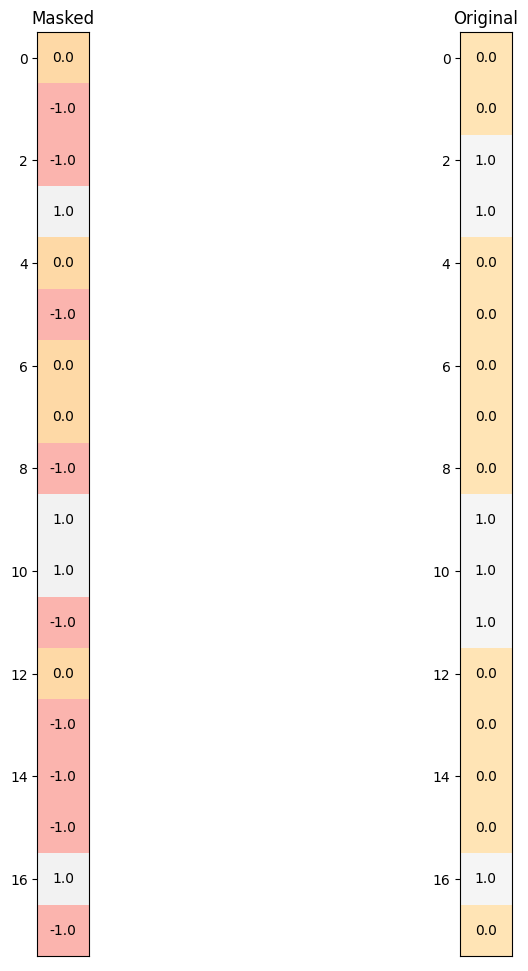

In [27]:
# Visualize the masking process in action on a sample person response
#visualize_masked_data(train)

# Create the masking encoder laye.
masked_encoder = MaskingEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    #unmasked_positions,
    mask_indices,
    unmask_indices,
) = masked_encoder(inputs=train)


# Show a maksed patch image.
new_masked, random_index = masked_encoder.generate_masked_items(train, unmask_indices)

fig, ax = plt.subplots(1, 2, figsize=(10, 12))

min_val, max_val = -1, 1

cmap = plt.cm.Pastel1

ax[0].matshow(new_masked, cmap=cmap)

rows = new_masked.shape[0]
cols = new_masked.shape[1]

for i in range(rows):
    for j in range(cols):
        c = new_masked[i,j]
        ax[0].text(j, i, str(c), va='center', ha='center')

ax[0].xaxis.set_visible(False)
ax[0].set_title('Masked')

cmp2 = mplt.colors.ListedColormap(['moccasin', 'whitesmoke'])

original = train[random_index].reshape(train.shape[1], 1)
ax[1].matshow(original, cmap=cmp2)

rows = original.shape[0]
cols = original.shape[1]

for i in range(rows):
    for j in range(cols):
        c = original[i,j]
        ax[1].text(j, i, str(c), va='center', ha='center')

ax[1].xaxis.set_visible(False)
ax[1].set_title('Original')

In [28]:
pred_test = downstream_data.iloc[:, 2:].values
print(pred_test.shape)
counts = np.count_nonzero(pred_test == -1, axis=1) == 5
print(counts)
input_data = pred_test[counts]
print(input_data.shape)

(1427, 18)
[False False False ... False False False]
(148, 18)


## MLP

This serves as the fully connected feed forward network of the transformer architecture.

In [29]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## MAE encoder

The MAE encoder is ViT. The only point to note here is that the encoder outputs a layer normalized output.## Enconder (after masking)

In [30]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

## MAE decoder

The authors point out that they use an asymmetric autoencoder model. They use a lightweight decoder that takes "<10% computation per token vs. the encoder". We are not specific with the "<10% computation" in our implementation but have used a smaller decoder (both in terms of depth and projection dimensions).



In [31]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, output_size=NUM_STATS
):
    inputs = layers.Input((NUM_STATS, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=output_size, activation="sigmoid")(x)
    outputs = layers.Reshape((output_size, 1))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


## MAE Model

In [32]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        masking_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.masking_encoder = masking_encoder
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        
        # Encode the inputs.
        (
            unmasked_embeddings,
            masked_embeddings,
            #unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.masking_encoder(inputs)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_embeddings #+ unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)

        return mask_indices, decoder_outputs

    def calculate_loss(self, input, mask_indices, decoder_outputs):

        loss_patch = tf.gather(input, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_outputs, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output    

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            mask_indices, decoder_outputs = self(inputs, training=True)
            total_loss, loss_patch, loss_output = self.calculate_loss(inputs, mask_indices, decoder_outputs)

        # Apply gradients.
        train_vars = [
            self.masking_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        mask_indices, decoder_outputs = self(inputs, training=True)
        total_loss, loss_patch, loss_output = self.calculate_loss(inputs, mask_indices, decoder_outputs)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}
    
    def predict(self, inputs):
        return self(inputs, training=False)


## Model initialization

In [33]:
masking_encoder = MaskingEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    masking_encoder=masking_encoder,
    encoder=encoder,
    decoder=decoder,
)


## Training callback 

### Visualization callback

In [34]:
# Taking a batch of test inputs to measure model's progress.

test_items = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.masking_encoder(test_items)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked, idx = self.model.masking_encoder.generate_masked_items(
                test_items, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original = test[idx].reshape(test.shape[1], 1)
            #test_masked_image = self.model.patch_layer.reconstruct_from_patch(
            #    test_masked_patch
            #)
            reconstructed = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 12))
            min_val, max_val = -1, 1

            rows = original.shape[0]
            cols = original.shape[1]

            cmap = plt.cm.Pastel1
            cmp2 = mplt.colors.ListedColormap(['moccasin', 'whitesmoke'])

            ax[0].matshow(original, cmap=cmp2)
            ax[0].xaxis.set_visible(False)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].matshow(test_masked, cmap=cmap)
            ax[1].xaxis.set_visible(False)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].matshow(reconstructed, cmap=cmp2)
            ax[2].xaxis.set_visible(False)
            ax[2].set_title(f"Reconstructed: {epoch:03d}")

            for i in range(rows):
                for j in range(cols):
                    c1 = original[i,j]
                    ax[0].text(j, i, str(c1), va='center', ha='center')
                    c2 = test_masked[i,j]
                    ax[1].text(j, i, str(c2), va='center', ha='center')
                    c3 = reconstructed[i,j]
                    if c3.numpy() < 0.5:
                        c3 = 0.
                    else:
                        c3 = 1.
                    ax[2].text(j, i, str(c3), va='center', ha='center')

### Learning rate scheduler

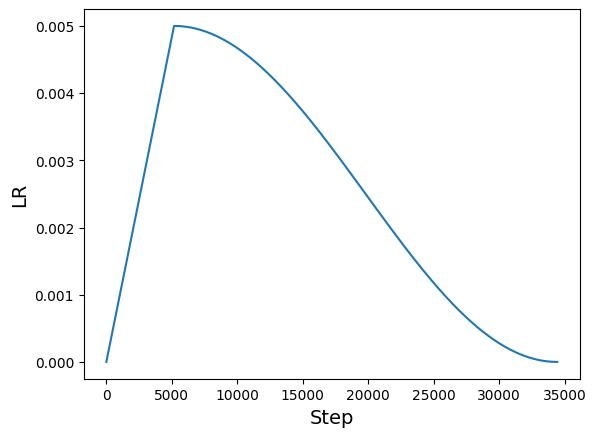

In [35]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )
    
    #def get_config(self):
    #    config = {
    #    'warmup_steps': self.warmup_steps
    #    }
    #    return config


total_steps = int((NUM_PERSONS / BATCH_SIZE) * NUM_EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]


# Model compilation and training

In [36]:
#optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

optimizer = keras.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and pretrain the model.
mae_model.masking_encoder.downstream = False

mae_model.compile(
    optimizer=optimizer, loss=LOSS, metrics=['binary_accuracy']
    #optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=['binary_accuracy']
)

start_time = time.time()
history = mae_model.fit(
    train_ds, 
    epochs=NUM_EPOCHS,
    validation_data=val_ds, 
    #callbacks=train_callbacks,
)
minutes, seconds = divmod(time.time() - start_time, 60)
print("--- %dmin %dsec ---" % (minutes, seconds))

# Measure its performance.
loss, ba = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"Binary Accuracy: {ba:.2f}")

# 10% imputation time execution = 4min 32sec 
# Loss: 0.04
# Binary Accuracy: 0.98
## Cross-tab for right imputation from orginal vs imputated. Shape=(215,18).
# masked transformer  0.0  1.0
# masked original             
# 0.0                       0
# 1.0                   5  166
# ----------------------------------------------------------------------
# 25% imputation time execution = 4min 26sec
# Loss: 0.10
# Binary Accuracy: 0.95
## Cross-tab for right imputation from orginal vs imputated. Shape=(215,18).
# masked transformer  0.0  1.0
# masked original             
# 0.0                 452   26
# 1.0                  21  361
# ----------------------------------------------------------------------
# 50% imputation time execution = 4min 12sec
# Loss: 0.17
# Binary Accuracy: 0.93
## Cross-tab for right imputation from orginal vs imputated. Shape=(215,18).
# masked transformer   0.0  1.0
# masked original              
# 0.0                 1014   78
# 1.0                   68  775
# -----------------------------------------------------------------------</s>

Epoch 1/100
345/345 [==============================] - 9s 9ms/step - loss: 0.6560 - binary_accuracy: 0.6253 - val_loss: 0.6040 - val_binary_accuracy: 0.6656
Epoch 2/100
345/345 [==============================] - 2s 7ms/step - loss: 0.5624 - binary_accuracy: 0.7007 - val_loss: 0.5157 - val_binary_accuracy: 0.7327
Epoch 3/100
345/345 [==============================] - 2s 7ms/step - loss: 0.5314 - binary_accuracy: 0.7261 - val_loss: 0.5251 - val_binary_accuracy: 0.7378
Epoch 4/100
345/345 [==============================] - 2s 7ms/step - loss: 0.5249 - binary_accuracy: 0.7292 - val_loss: 0.5079 - val_binary_accuracy: 0.7486
Epoch 5/100
345/345 [==============================] - 2s 7ms/step - loss: 0.5165 - binary_accuracy: 0.7337 - val_loss: 0.5077 - val_binary_accuracy: 0.7215
Epoch 6/100
345/345 [==============================] - 2s 7ms/step - loss: 0.5117 - binary_accuracy: 0.7384 - val_loss: 0.5140 - val_binary_accuracy: 0.7419
Epoch 7/100
345/345 [==============================] - 2s 

In [37]:
print(train.shape)

(1722, 18, 1)


In [38]:
print(test.shape)

(215, 18, 1)


# Test extraction

## Generate masked data function

In [39]:
def generate_masked_data(inputs, unmask_indices):
    # Build a numpy array of same shape as patch.
    unmask = unmask_indices.numpy()
    new_data = -np.ones_like(inputs)

    # Iterate of the new_patch and plug the unmasked inputs.
    #for i in range(unmask_indices.shape[0]):
    #    new_patch[unmask_index[i]] = patch[unmask_index[i]]
    #eturn new_patch, idx

    for idx in range(inputs.shape[0]):
        new_data[idx][unmask[idx]] = inputs[idx][unmask[idx]]

    return new_data

## Extract the encoder model along with other layers

In [40]:
dsd = downstream_data.iloc[:, 2:].values[..., np.newaxis]



In [41]:
(
    test_unmasked_embeddings,
    test_masked_embeddings,
    #test_unmasked_positions,
    test_mask_indices,
    test_unmask_indices
) = mae_model.masking_encoder(test)
test_encoder_outputs = mae_model.encoder(test_unmasked_embeddings)
test_encoder_outputs = test_encoder_outputs + test_unmasked_embeddings
test_decoder_inputs = tf.concat(
    [test_encoder_outputs, test_masked_embeddings], axis=1
)
test_decoder_outputs = mae_model.decoder.predict(test_decoder_inputs)

masked = generate_masked_data(test, test_unmask_indices)

#pred = test_decoder_outputs
pred = np.squeeze(test_decoder_outputs, axis=2)
print(pred.shape)  

m = np.squeeze(masked, axis=2)
print(m.shape)

if ' ' in CNT_NAME:
    CNT_NAME = CNT_NAME.replace(' ', '_')

name = CNT_NAME

if ALL_CNTS:
    name = 'ALL_CNTS'

np.savetxt('output_data/' + PERCENTAGE + '_missing/y/ypred_transformer_' + PERCENTAGE + '_missing_' + name + '.csv', pred, delimiter=';')
np.savetxt('output_data/' + PERCENTAGE + '_missing/masked/masked_pred_' + PERCENTAGE + '_missing_' + name + '.csv', m,  delimiter=';')


7/7 [==============================] - 0s 5ms/step
(215, 18)
(215, 18)


In [91]:
pred.shape

(215, 18)

In [43]:
input_data.shape

(148, 18)

In [44]:
mae_model.masking_encoder.downstream = True

#(
#    pred_unmasked_embeddings,
#    pred_masked_embeddings,
#    pred_unmasked_positions,
#    pred_mask_indices,
#    pred_unmask_indices
#) 
pred_decoder_inputs = mae_model.masking_encoder(dsd)
#pred_encoder_outputs = mae_model.encoder(pred_unmasked_embeddings)
#pred_encoder_outputs = pred_encoder_outputs + pred_unmasked_positions
#pred_decoder_inputs = tf.concat(
#    [pred_encoder_outputs, pred_masked_embeddings], axis=1
#)

pred_decoder_outputs = mae_model.decoder(pred_decoder_inputs)

In [45]:
pred_downstream = np.squeeze(pred_decoder_outputs, axis=2)

In [46]:
pred_downstream

array([[4.1170232e-02, 2.4106991e-01, 6.3496447e-01, ..., 3.2960048e-01,
        2.3582386e-02, 3.7110549e-01],
       [1.3457001e-03, 2.2517879e-02, 1.3335610e-03, ..., 1.5356681e-04,
        3.9619035e-03, 1.7396711e-04],
       [1.1612200e-02, 1.9591646e-01, 9.5259565e-01, ..., 6.6494805e-01,
        2.2526125e-05, 8.7660067e-03],
       ...,
       [1.4638323e-02, 8.1117727e-02, 9.9710412e-02, ..., 3.5916410e-02,
        1.5115133e-01, 4.1287649e-02],
       [1.9932551e-02, 2.1617476e-02, 9.8221093e-01, ..., 7.9436183e-01,
        5.1226820e-08, 1.5259121e-06],
       [3.2783285e-02, 3.2152611e-01, 1.4526896e-01, ..., 1.7197257e-02,
        1.3663201e-04, 3.5555099e-06]], dtype=float32)

## Change continuous values of prediction to categorical

In [47]:
trn = np.ones_like(pred)
trn[pred < 0.5] = 0
trn_downstream = np.ones_like(pred_downstream)
trn_downstream[pred_downstream < 0.5] = 0

#np.set_printoptions(precision=2)
print(pred)
print(trn)
print("---")
print(pred_downstream)
print(trn_downstream)

[[2.78561114e-04 1.55223301e-04 1.07217056e-05 ... 2.13674093e-06
  6.16952821e-06 2.00937984e-06]
 [2.95410027e-05 4.81318275e-05 8.56681727e-05 ... 9.22414802e-06
  1.37571566e-04 1.76762223e-05]
 [1.11097214e-03 5.58680680e-04 4.46644890e-06 ... 8.55785800e-07
  2.38520448e-09 1.16131005e-05]
 ...
 [7.95572042e-01 8.22794199e-01 8.49968612e-01 ... 6.84909940e-01
  4.63344127e-01 7.08791912e-01]
 [1.02756703e-02 3.79366092e-02 1.12141080e-01 ... 1.18635744e-02
  7.35513330e-01 9.43821073e-01]
 [4.05747034e-02 5.63146360e-03 5.02132578e-03 ... 1.44570135e-03
  1.91236271e-09 2.22224713e-04]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
---
[[4.1170232e-02 2.4106991e-01 6.3496447e-01 ... 3.2960048e-01
  2.3582386e-02 3.7110549e-01]
 [1.3457001e-03 2.2517879e-02 1.3335610e-03 ... 1.5356681e-04
  3.9619035e-03 1.7396711e-04]
 [1.1612200e-02 1.9591646e-01 9.5259565e-01 ... 6.6494

In [48]:
trn_downstream[trn_downstream == 1.]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [49]:
print(downstream_data.values[:, 2:].shape)
print(trn_downstream.shape)

(1427, 18)
(1427, 18)


## Visualize the imputed results

In [50]:
masked_indices = []
unmasked_indices = []

for i in range(m.shape[0]):
    d = []
    u = []
    for j in range(m.shape[1]):
        if m[i,j] == -1:
            d.append(j)
        else:
            u.append(j)        
    masked_indices.append(d)
    unmasked_indices.append(u)

masked_indices = np.array(masked_indices)
unmasked_indices = np.array(unmasked_indices)

In [51]:
downstream_masked_indices = []
downstream_unmasked_indices = []

for i in range(m.shape[0]):
    d = []
    u = []
    for j in range(m.shape[1]):
        if m[i,j] == -1:
            d.append(j)
        else:
            u.append(j)        
    downstream_masked_indices.append(d)
    downstream_unmasked_indices.append(u)

downstream_masked_indices = np.array(masked_indices)
downstream_unmasked_indices = np.array(unmasked_indices)

In [52]:
mo = np.ndarray(masked_indices.shape)
mt = np.ndarray(masked_indices.shape)

uo = np.ndarray(unmasked_indices.shape)
ut = np.ndarray(unmasked_indices.shape)

tst = np.squeeze(test, axis=2)
print(tst.shape)

for i in range(masked_indices.shape[0]):
    mo[i] = tst[i, :][masked_indices[i,:]]
    mt[i] = trn[i, :][masked_indices[i,:]]

for i in range(unmasked_indices.shape[0]):
    uo[i] = tst[i, :][unmasked_indices[i,:]]
    ut[i] = trn[i, :][unmasked_indices[i,:]]

(215, 18)


In [53]:
dmo = np.ndarray(downstream_masked_indices.shape)
dmt = np.ndarray(downstream_masked_indices.shape)

duo = np.ndarray(downstream_unmasked_indices.shape)
dut = np.ndarray(downstream_unmasked_indices.shape)

tst = np.squeeze(test, axis=2)
print(tst.shape)

for i in range(downstream_masked_indices.shape[0]):
    dmo[i] = tst[i, :][downstream_masked_indices[i,:]]
    #dmt[i] = trn_downstream[i, :][downstream_masked_indices[i,:]]

for i in range(downstream_unmasked_indices.shape[0]):
    duo[i] = tst[i, :][downstream_unmasked_indices[i,:]]
    dut[i] = trn_downstream[i, :][downstream_unmasked_indices[i,:]]

(215, 18)


In [54]:
data = {'masked original': mo.flatten(), 'masked transformer': mt.flatten()}
data1 = {'unmasked original': uo.flatten(), 'unmasked transformer': ut.flatten()}
#data2 = {'downstream masked original': dmo.flatten(), 'downstream masked transformer': dmt.flatten()}
#data3 = {'downstream unmasked original': duo.flatten(), 'downstream unmasked transformer': dut.flatten()}

df = pd.DataFrame(data)
df1 = pd.DataFrame(data1)
#df2 = pd.DataFrame(data2)
#df3 = pd.DataFrame(data3)

cm = pd.crosstab(df['masked original'], df['masked transformer'])
cm1 = pd.crosstab(df1['unmasked original'], df1['unmasked transformer'])
#cm2 = pd.crosstab(df2['downstream masked original'], df2['downstream masked transformer'])
#cm3 = pd.crosstab(df3['downstream unmasked original'], df3['downstream unmasked transformer'])

print(cm)
print(cm1)
#print(cm2)
#print(cm3)

cmp = pd.crosstab(df['masked original'], df['masked transformer']).apply(lambda s: (s/s.sum() * 100), axis=1)
cmp1 = pd.crosstab(df1['unmasked original'], df1['unmasked transformer']).apply(lambda r: (r/r.sum() * 100), axis=1)
#cmp2 = pd.crosstab(df2['downstream masked original'], df2['downstream masked transformer']).apply(lambda r: (r/r.sum() * 100), axis=1)
#cmp3 = pd.crosstab(df3['downstream unmasked original'], df3['downstream unmasked transformer']).apply(lambda r: (r/r.sum() * 100), axis=1)

print(cmp)
print(cmp1)
#print(cmp2)
#print(cmp3)

masked transformer   0.0  1.0
masked original              
0.0                 1014   78
1.0                   68  775
unmasked transformer  0.0  1.0
unmasked original             
0.0                   828  242
1.0                   471  394
masked transformer        0.0        1.0
masked original                         
0.0                 92.857143   7.142857
1.0                  8.066429  91.933571
unmasked transformer        0.0        1.0
unmasked original                         
0.0                   77.383178  22.616822
1.0                   54.450867  45.549133


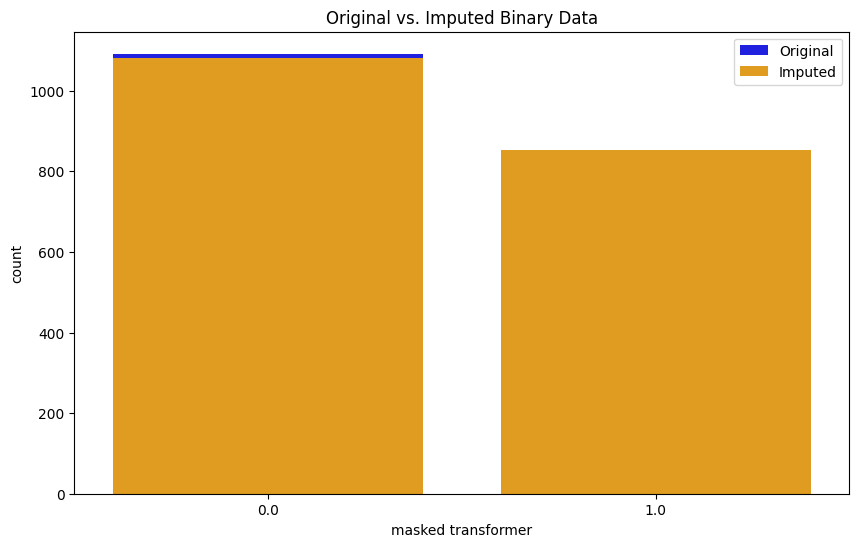

In [92]:
# Plot original vs. imputed using a stacked bar chart
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='masked original', color='blue', label='Original')
sns.countplot(data=df, x='masked transformer', color='orange', label='Imputed')
plt.title('Original vs. Imputed Binary Data')
plt.legend()
plt.show()

In [55]:
print(mo.shape)
print(mt.shape)

(215, 9)
(215, 9)


In [56]:
'''
for idx in range(0, mt.shape[0]):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 8))

    original = mo[idx].reshape([mo.shape[1], 1])
    transformer = mt[idx].reshape([mt.shape[1], 1])

    rows = transformer.shape[0]
    cols = transformer.shape[1]

    cmap = plt.cm.Pastel1

    ax[0].matshow(original, cmap=cmap)
    ax[0].xaxis.set_visible(False)
    ax[0].set_title(f"Original: {idx:03d}")

    ax[1].matshow(transformer, cmap=cmap)
    ax[1].xaxis.set_visible(False)
    ax[1].set_title(f"Transformer: {idx:03d}")

    for i in range(rows):
        for j in range(cols):
            c1 = original[i,j]
            ax[0].text(j, i, str(c1), va='center', ha='center')
            ax[0].tick_params(left=False, labelleft=False)
            c2 = transformer[i,j]
            ax[1].text(j, i, str(c2), va='center', ha='center')
            ax[1].tick_params(left=False, labelleft=False)
'''

'\nfor idx in range(0, mt.shape[0]):\n\n    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 8))\n\n    original = mo[idx].reshape([mo.shape[1], 1])\n    transformer = mt[idx].reshape([mt.shape[1], 1])\n\n    rows = transformer.shape[0]\n    cols = transformer.shape[1]\n\n    cmap = plt.cm.Pastel1\n\n    ax[0].matshow(original, cmap=cmap)\n    ax[0].xaxis.set_visible(False)\n    ax[0].set_title(f"Original: {idx:03d}")\n\n    ax[1].matshow(transformer, cmap=cmap)\n    ax[1].xaxis.set_visible(False)\n    ax[1].set_title(f"Transformer: {idx:03d}")\n\n    for i in range(rows):\n        for j in range(cols):\n            c1 = original[i,j]\n            ax[0].text(j, i, str(c1), va=\'center\', ha=\'center\')\n            ax[0].tick_params(left=False, labelleft=False)\n            c2 = transformer[i,j]\n            ax[1].text(j, i, str(c2), va=\'center\', ha=\'center\')\n            ax[1].tick_params(left=False, labelleft=False)\n'

# Training Function

## Change only imputed values from masked

In [57]:
print(masked.shape)
print(trn.shape)
print(all_test.shape)

(215, 18, 1)
(215, 18)
(215, 19)


In [58]:
tes = all_test.values[:, :-1]
for i in range(masked.shape[0]):
    for j in range(masked.shape[1]):
        if masked[i, j] != -1 and trn[i, j] != tes[i, j]:
            trn[i, j] = tes[i, j]

In [59]:
for i in range(downstream_data.values[:, 2:].shape[0]):
    for j in range(downstream_data.values[:, 2:].shape[1]):
        if downstream_data.values[:, 2:][i, j] != -1 and trn_downstream[i, j] != downstream_data.values[:, 2:][i, j]:
            trn_downstream[i, j] = downstream_data.values[:, 2:][i, j]

In [60]:
print(trn.shape)

(215, 18)


In [61]:
for i in range(1):
    
    vae_q = VariationalAutoEncoder(NUM_STATS, INTERMEDIATE_DIM, NUM_SKILLS)

    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True)
    #opt = tf.keras.optimizers.SGD(learning_rate=0.005)
    
    vae_q.compile(optimizer=opt, loss=vae_q.vae_loss, metrics=['binary_accuracy'])

    history = vae_q.fit(trn,
                        trn,
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        shuffle=True)
    # validation_split=0.2

    encoder = vae_q.get_encoder()
    #weights = vae_q.get_decoder().trainable_weights

    weights = vae_q._get_weights()

    discr = weights[0].numpy()
    #print(discr.shape)
    #diff = pd.DataFrame(weights[3].numpy())
    negative_diff = pd.DataFrame(np.negative(weights[1].numpy()))

    # Get latent trait predictions
    thetas_hat, log_var_thetas_hat, z_pred = encoder.predict(trn)
    #pred = encoder.predict_step(data_train)
    #print(pred)
    #print(thetas_hat)

    # Total score on the test -------
    score = np.apply_over_axes(np.sum, trn, 1)

    #### Vectoring the matrices Thetas_hat ans discr ####
    theta_hat = np.transpose(thetas_hat).flatten()
    #step_theta_hat = np.transpose(step_thetas_hat.numpy()).flatten()
  
    log_var_theta_hat = np.transpose(log_var_thetas_hat).flatten()
    #step_log_var_theta_hat = np.transpose(step_log_var_thetas_hat.numpy()).flatten()

    discr_hat = remove_zeros(discr)

    # Save results
    theta_est_rep_GUI = pd.DataFrame({'Thetas Estimation': theta_hat, 'Log Var Thetas Estimation': log_var_theta_hat})
    theta_est_rep_GUI.to_csv('output_data/' + PERCENTAGE + '_missing/thetas/thetas_transformer_' + PERCENTAGE + '_missing_' + name + '.csv', sep=';', index=False)

    discr_hat_GUI = pd.DataFrame([discr_hat])
    discr_hat_GUI.T.to_csv('output_data/' + PERCENTAGE + '_missing/a/a_transformer_' + PERCENTAGE + '_missing_' + name + '.csv', sep=';', index=False, header=False)

    negative_diff.to_csv('output_data/' + PERCENTAGE + '_missing/b/b_transformer_' + PERCENTAGE + '_missing_' + name + '.csv', sep=';', index=False, header=False)


Epoch 1/100
Pegou o decoder!
Pegou o decoder!
43/43 [==============================] - 1s 729us/step - loss: 12.4811 - binary_accuracy: 0.6041
Epoch 2/100
43/43 [==============================] - 0s 688us/step - loss: 11.9063 - binary_accuracy: 0.6579
Epoch 3/100
43/43 [==============================] - 0s 565us/step - loss: 11.5779 - binary_accuracy: 0.6744
Epoch 4/100
43/43 [==============================] - 0s 555us/step - loss: 11.2488 - binary_accuracy: 0.6953
Epoch 5/100
43/43 [==============================] - 0s 670us/step - loss: 10.9369 - binary_accuracy: 0.7150
Epoch 6/100
43/43 [==============================] - 0s 653us/step - loss: 10.5996 - binary_accuracy: 0.7320
Epoch 7/100
43/43 [==============================] - 0s 856us/step - loss: 10.2770 - binary_accuracy: 0.7457
Epoch 8/100
43/43 [==============================] - 0s 1ms/step - loss: 10.0209 - binary_accuracy: 0.7568
Epoch 9/100
43/43 [==============================] - 0s 713us/step - loss: 9.8716 - binary_accur

In [62]:
print(theta_hat.shape)
print(thetas_hat.shape)
print(trn.shape)

(860,)
(215, 4)
(215, 18)


<AxesSubplot: ylabel='Count'>

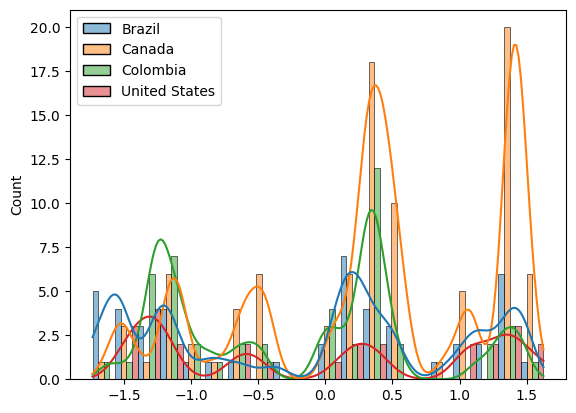

In [63]:
sns.histplot(x=thetas_hat[: ,0], hue=all_countries_name, multiple='dodge', kde=True, stat='count', bins=20, kde_kws = {'bw_adjust': 0.2})

<AxesSubplot: ylabel='Count'>

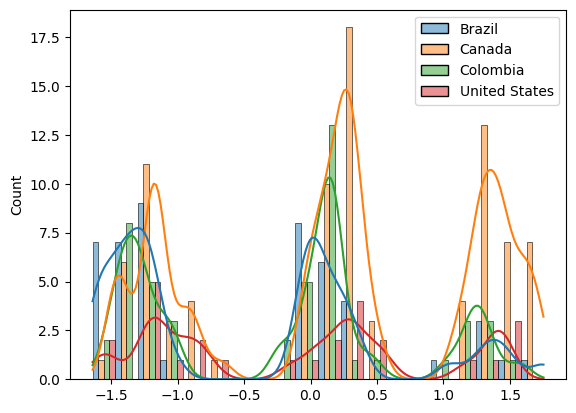

In [64]:
sns.histplot(x=thetas_hat[: ,1], hue=all_countries_name, multiple='dodge', kde=True, stat='count', bins=20, kde_kws = {'bw_adjust': 0.2})

<AxesSubplot: ylabel='Count'>

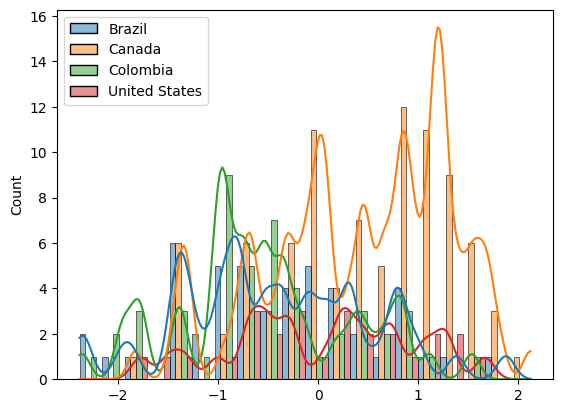

In [65]:
sns.histplot(x=thetas_hat[: ,2], hue=all_countries_name, multiple='dodge', kde=True, stat='count', bins=20, kde_kws = {'bw_adjust': 0.2})

<AxesSubplot: ylabel='Count'>

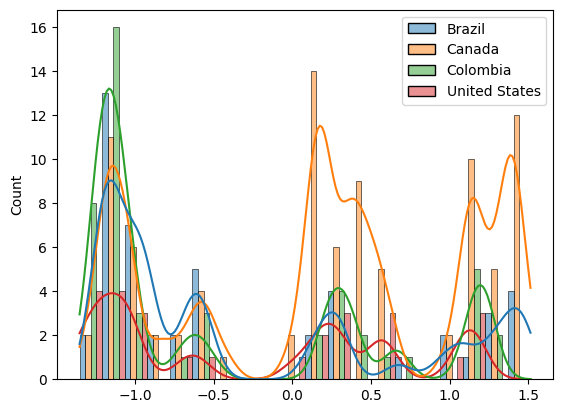

In [66]:
sns.histplot(x=thetas_hat[: ,3], hue=all_countries_name, multiple='dodge', kde=True, stat='count', bins=20, kde_kws = {'bw_adjust': 0.2})

In [67]:
perc = []
for line in trn:
    perc.append((np.count_nonzero(line)/18)*100)
    print('%.2f' % ((np.count_nonzero(line)/18)*100))


16.67
16.67
33.33
61.11
83.33
33.33
77.78
33.33
22.22
5.56
33.33
16.67
22.22
38.89
11.11
27.78
16.67
33.33
44.44
72.22
27.78
11.11
55.56
33.33
38.89
88.89
22.22
16.67
55.56
55.56
27.78
0.00
33.33
50.00
33.33
16.67
22.22
27.78
50.00
22.22
11.11
22.22
55.56
11.11
33.33
50.00
16.67
22.22
61.11
22.22
72.22
38.89
44.44
55.56
44.44
27.78
66.67
38.89
55.56
38.89
55.56
38.89
66.67
27.78
88.89
27.78
72.22
55.56
33.33
83.33
61.11
38.89
72.22
16.67
50.00
72.22
83.33
66.67
44.44
27.78
50.00
77.78
50.00
33.33
61.11
44.44
44.44
55.56
44.44
61.11
66.67
33.33
66.67
83.33
55.56
44.44
77.78
77.78
50.00
50.00
66.67
44.44
77.78
66.67
27.78
66.67
55.56
77.78
77.78
83.33
27.78
61.11
72.22
5.56
22.22
55.56
38.89
77.78
55.56
44.44
55.56
83.33
61.11
16.67
77.78
38.89
55.56
83.33
66.67
66.67
83.33
77.78
55.56
50.00
72.22
50.00
55.56
33.33
38.89
55.56
16.67
27.78
38.89
44.44
16.67
44.44
22.22
16.67
38.89
22.22
22.22
33.33
55.56
44.44
44.44
27.78
16.67
50.00
22.22
27.78
61.11
22.22
50.00
38.89
44.44
61.11
11.11
5

<AxesSubplot: ylabel='Percent'>

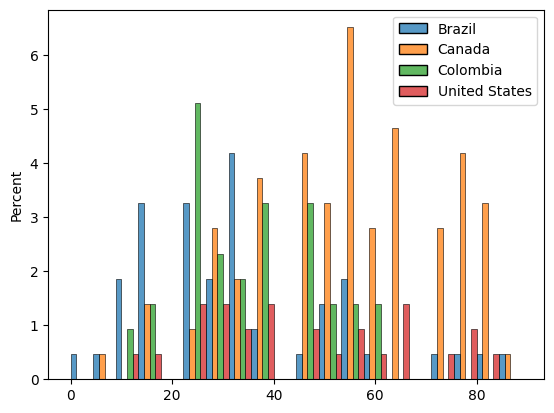

In [68]:
sns.histplot(x=perc, hue=all_countries_name, multiple='dodge', stat='percent', bins=20)

In [69]:
for i in range(1):
    
    vae_q = VariationalAutoEncoder(NUM_STATS, INTERMEDIATE_DIM, NUM_SKILLS)

    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True)
    #opt = tf.keras.optimizers.SGD(learning_rate=0.005)
    
    vae_q.compile(optimizer=opt, loss=vae_q.vae_loss, metrics=['binary_accuracy'])

    history = vae_q.fit(trn_downstream,
                        trn_downstream,
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        shuffle=True)
    # validation_split=0.2

    encoder = vae_q.get_encoder()
    #weights = vae_q.get_decoder().trainable_weights

    weights = vae_q._get_weights()

    discr = weights[0].numpy()
    #print(discr.shape)
    #diff = pd.DataFrame(weights[3].numpy())
    negative_diff = pd.DataFrame(np.negative(weights[1].numpy()))

    # Get latent trait predictions
    thetas_hat, log_var_thetas_hat, z_pred = encoder.predict(trn_downstream)
    #pred = encoder.predict_step(data_train)
    #print(pred)
    #print(thetas_hat)

    # Total score on the test -------
    score = np.apply_over_axes(np.sum, trn_downstream, 1)

    #### Vectoring the matrices Thetas_hat ans discr ####
    theta_hat = np.transpose(thetas_hat).flatten()
    #step_theta_hat = np.transpose(step_thetas_hat.numpy()).flatten()
  
    log_var_theta_hat = np.transpose(log_var_thetas_hat).flatten()
    #step_log_var_theta_hat = np.transpose(step_log_var_thetas_hat.numpy()).flatten()

    discr_hat = remove_zeros(discr)

    # Save results
    theta_est_rep_GUI = pd.DataFrame({'Thetas Estimation': theta_hat, 'Log Var Thetas Estimation': log_var_theta_hat})
    theta_est_rep_GUI.to_csv('output_data/' + PERCENTAGE + '_missing/downstream/thetas_transformer_' + PERCENTAGE + '_missing_' + name + '.csv', sep=';', index=False)

    discr_hat_GUI = pd.DataFrame([discr_hat])
    discr_hat_GUI.T.to_csv('output_data/' + PERCENTAGE + '_missing/downstream/a_transformer_' + PERCENTAGE + '_missing_' + name + '.csv', sep=';', index=False, header=False)

    negative_diff.to_csv('output_data/' + PERCENTAGE + '_missing/downstream/b_transformer_' + PERCENTAGE + '_missing_' + name + '.csv', sep=';', index=False, header=False)


Epoch 1/100
Pegou o decoder!
Pegou o decoder!
286/286 [==============================] - 1s 674us/step - loss: 10.7540 - binary_accuracy: 0.7309
Epoch 2/100
286/286 [==============================] - 0s 594us/step - loss: 9.1685 - binary_accuracy: 0.7768
Epoch 3/100
286/286 [==============================] - 0s 635us/step - loss: 8.8107 - binary_accuracy: 0.7841
Epoch 4/100
286/286 [==============================] - 0s 572us/step - loss: 8.6852 - binary_accuracy: 0.7885
Epoch 5/100
286/286 [==============================] - 0s 617us/step - loss: 8.5833 - binary_accuracy: 0.7905
Epoch 6/100
286/286 [==============================] - 0s 528us/step - loss: 8.5193 - binary_accuracy: 0.7903
Epoch 7/100
286/286 [==============================] - 0s 546us/step - loss: 8.4907 - binary_accuracy: 0.7908
Epoch 8/100
286/286 [==============================] - 0s 530us/step - loss: 8.4399 - binary_accuracy: 0.7923
Epoch 9/100
286/286 [==============================] - 0s 534us/step - loss: 8.4222 -

In [70]:
print(theta_hat.shape)
print(thetas_hat.shape)
print(trn.shape)

(5708,)
(1427, 4)
(215, 18)


<AxesSubplot: ylabel='Count'>

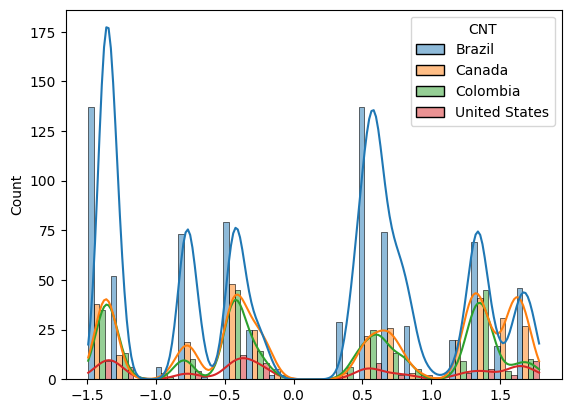

In [71]:
sns.histplot(x=thetas_hat[: ,0], hue=downstream_data['CNT'], multiple='dodge', kde=True, stat='count', bins=20, kde_kws = {'bw_adjust': 0.2})

<AxesSubplot: ylabel='Count'>

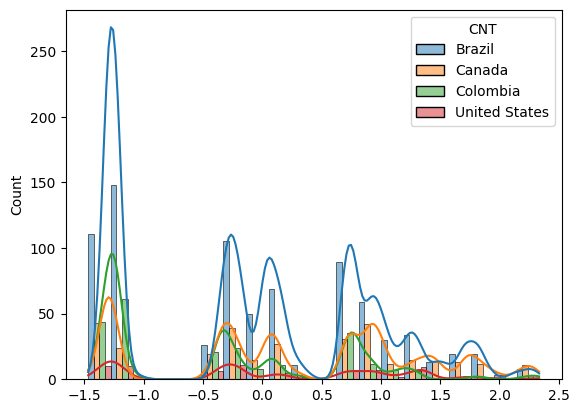

In [72]:
sns.histplot(x=thetas_hat[: ,1], hue=downstream_data['CNT'], multiple='dodge', kde=True, stat='count', bins=20, kde_kws = {'bw_adjust': 0.2})

<AxesSubplot: ylabel='Count'>

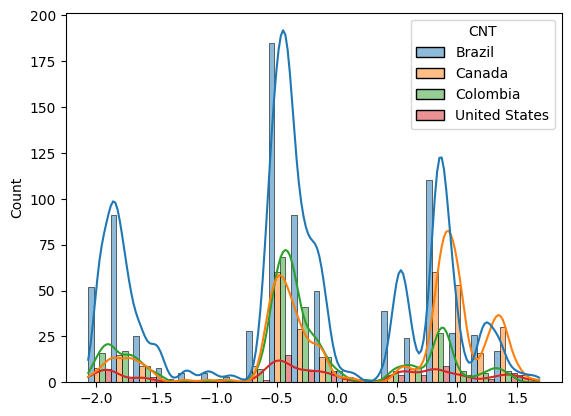

In [73]:
sns.histplot(x=thetas_hat[: ,2], hue=downstream_data['CNT'], multiple='dodge', kde=True, stat='count', bins=20, kde_kws = {'bw_adjust': 0.2})

<AxesSubplot: ylabel='Count'>

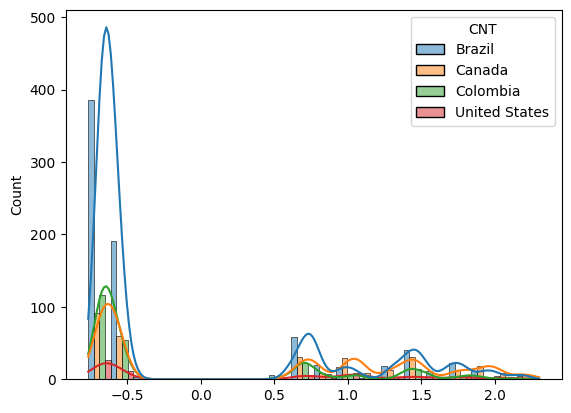

In [74]:
sns.histplot(x=thetas_hat[: ,3], hue=downstream_data['CNT'], multiple='dodge', kde=True, stat='count', bins=20, kde_kws = {'bw_adjust': 0.2})

In [75]:
perc = []
for line in trn_downstream:
    perc.append((np.count_nonzero(line)/18)*100)
    print('%.2f' % ((np.count_nonzero(line)/18)*100))


33.33
33.33
55.56
16.67
33.33
22.22
22.22
16.67
22.22
22.22
50.00
5.56
22.22
61.11
27.78
27.78
27.78
50.00
33.33
22.22
38.89
11.11
33.33
11.11
44.44
44.44
11.11
44.44
22.22
27.78
27.78
38.89
27.78
11.11
27.78
16.67
44.44
11.11
22.22
5.56
16.67
11.11
22.22
16.67
55.56
11.11
66.67
33.33
61.11
5.56
27.78
27.78
27.78
27.78
16.67
0.00
16.67
5.56
27.78
38.89
22.22
11.11
27.78
16.67
50.00
5.56
22.22
66.67
33.33
16.67
27.78
16.67
11.11
27.78
50.00
44.44
11.11
27.78
11.11
44.44
22.22
22.22
38.89
38.89
27.78
0.00
33.33
5.56
16.67
11.11
22.22
38.89
33.33
50.00
27.78
16.67
27.78
55.56
33.33
33.33
50.00
33.33
11.11
16.67
66.67
5.56
11.11
33.33
66.67
27.78
33.33
38.89
22.22
33.33
22.22
33.33
50.00
33.33
44.44
11.11
16.67
0.00
16.67
27.78
44.44
22.22
22.22
22.22
33.33
44.44
44.44
33.33
27.78
11.11
27.78
27.78
27.78
16.67
38.89
55.56
0.00
5.56
33.33
22.22
38.89
0.00
16.67
38.89
22.22
16.67
5.56
33.33
33.33
38.89
11.11
61.11
16.67
16.67
27.78
11.11
11.11
16.67
33.33
27.78
22.22
16.67
22.22
11.11
22.22


<AxesSubplot: ylabel='Percent'>

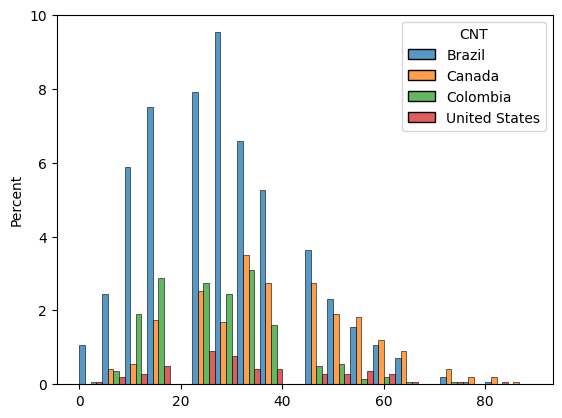

In [76]:
sns.histplot(x=perc, hue=downstream_data['CNT'], multiple='dodge', stat='percent', bins=20)